# Bank Marketing Prediction

## Table of Contents
1 [Project Summary](#summary)  
2 [Loading](#loading)  
2.1 [Import Libraries](#libraries)  
2.2 [Import Data](#data)  
2.3 [Functions](#function)  
3 [Exploring the data](#eda)  
3.1 [Data Overview](#overview)  
3.1.1 [Input Variables](#input)  
3.2 [Data Cleaning](#cleaning)  
3.3 [Visualisation](#visualisations)  
3.4 [Feature Engineering](#feature)  
3.5 [Preprocessing](#preprocess)  
4 [Model Deployment](#modeldep)  
4.1 [Model Development](#developmodel)  
4.2 [Model Tuning](#modeltune)  
4.3 [Model Validation](#validate)  
5 [Deploy](#deploy)  

# Project Summary 
<a id="summary"></a>
***
**Situation**  
Direct marketing campaign is one of the main strategies to enhance the business in banking industry and identifying target clients is a critical problem to make a campaign success. This project aims to predict  whether a client will subscribe bank term deposit or not as a result of marketing efforts.
  
**Action and Goal**  
Using the data related to direct marketing campaign of a Portuguese banking institution, exploratory data analysis (EDA) and model deployment are implemented by using Python and jupyter notebook. The goal is to build a model that predicts the client's decision ('yes' or 'no'). Since the output from the model is expected to be binary, a binary model is needed to be built by exploring classification algorithms such as decision tree, random forest, support vector machine (SVM) and neural networks. The deployed model is evaluated by the accuracy of the prediction and the ROC curve.  
  
**Output**  
(later... ex. The model built by XXXX predicts the client's decision with the accuracy of XX% and ROC curve shows XXXXX)

# Loading
<a id="loading"></a>

## Import Libraries
<a id="libraries"></a>
***
These libraries can be installed from **Pipfile** and **Pipfile.lock** using pipenv (**Python version: 3.7.5**)

In [144]:
# Import libraries
import os, sys
sys.path.append(os.pardir) # to import files in the parent directory
import math
import calendar

import numpy as np
import pandas as pd
import pandas_profiling as pdp

import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.io as pio
pio.renderers.default='iframe'

import sklearn as sk


## Import data
<a id="data"></a>
***
  
**Files in "data" directory:**  
  
- bank.csv: 10% of the examples and 17 inputs, randomly selected from 3 (older version of this dataset with less inputs).  

- bank-full.csv: all examples and 17 inputs, ordered by date (older version of this dataset with less inputs)   

- bank-names.txt: Attributes for bank-full.csv and bank.csv

- bank-additional.csv: 10% of the examples (4119), randomly selected from 1), and 20 inputs.  

- bank-additional-full.csv: all examples (41188) and 20 inputs, ordered by date (from May 2008 to November 2010), very close to the data analyzed in (Moro et al., 2014)  

- bank-additional-names.txt: Attributes for bank-additional-full.csv and bnak-additional.csv  

(Moro et al., 2014) S. Moro, P. Cortez and P. Rita. A Data-Driven Approach to Predict the Success of Bank Telemarketing. Decision Support Systems, Elsevier, 62:22-31, June 2014

In [13]:
# import data
# data_full = pd.read_csv("data/bank-full.csv", sep=";")
data_add_full = pd.read_csv("data/bank-additional-full.csv", sep=";")

## Functions
<a id="function"></a>
***
Defined custom functions are shown in this section.

***
***
**Data Profile**
***
This function provides a summary of data structure in dataframe such as data types, count of the null data and count of the unique values. (See [Profile](#profile))

In [16]:
def data_profile(df):
    import math
    # Datatype
    df_dtype = pd.DataFrame(df.dtypes)
    
    # Null count
    df_null = pd.DataFrame(df.isnull().sum())
    # Null ratio (%)
    null_ratio = df.isnull().sum() / df.shape[0] * 100 #Percentage
    null_ratio = null_ratio.apply(lambda x: math.floor(x * 10**2) / 10**2) #rounding
    df_null_ratio = pd.DataFrame(null_ratio)
    
    # Non-null count
    df_notnull = pd.DataFrame(df.notnull().sum())
    
    # Unique value/Unique ratio(%)
    df_unique = {}
    df_unique_ratio = {}
    
    for column in df.columns:
        df_unique[column] = len(df[column].value_counts())
        df_unique_ratio[column] = len(df[column].value_counts()) / df.shape[0] *100 #Percentage
        
    df_unique = pd.DataFrame.from_dict(df_unique, orient='index')
    df_unique_ratio = pd.DataFrame.from_dict(df_unique_ratio, orient='index')
    df_unique_ratio = df_unique_ratio[0].apply(lambda x: math.floor(x * 10**2) / 10**2) #rounding
    
    # Create a new dataframe showing the data profile 
    df_profile = pd.concat([df_dtype, df_null, df_null_ratio, df_notnull, df_unique, df_unique_ratio], axis=1).reset_index()
    df_profile.columns = ['Column', 'Data type', 'Null count', 'Null ratio (%)', 'Non-null count', 'Distinct', 'Distinct (%)']
    
    return df_profile

***
***
**Get summry statistics of grouped data**
***
This function generates a dataframe as dictionary that contains summary statistics of grouped data.(See [](#))  

In [7]:
def grouped_data_summary(df, group_by ,group_key, agg_functions, new_col_names):
    ''' Get summary statistics of grouped data
    
    Parameters
    ----------
    df (dataframe):
    group_by (list): 
    key (list): 
    agg_function: aggregation functions (sum, mean, max, min,...)
    
    Return
    ----------
    df_dict - modified dataframe in dictionary format
    '''
    
    # Create a dictinary
    df_dict = {}
    
    for group_name in group_by:
        # get the data based on group
        df_modi = (
            df.groupby(group_name)[group_key]
            .agg(agg_functions)
        )
        
        # Rename column names
        df_modi.columns = new_col_names
        
        # Reset index
        df_modi = df_modi.reset_index()
        
        # Store the results in the dictonary
        df_dict[group_name] = df_modi
    
    return df_dict

***
***
**Barplots**
***
***barplot_plt()*** generates bar chart(s) using ***matplotlib*** on a single plot or multiple plots. Dataframe must be dictionary format which is an output from ***groupby_summary()***

In [26]:
# Matplotlib
def barplot_plt(df, x_cols, y_col, plot_ax=0, fig_unit_size=[20,10]):
    """ Bar chart generated by matplotlib
    This plot can show multi panel plots
    
    Parameters
    ----------
    df (dataframe in dictionary)
    x_cols (list):
    y_col (string): ex) 'a' 
    plot_ax(0 or 1, Default:0)
    fig_unit_size: figure size per one figure
    """
    import matplotlib.colors as mcolors
    # check the input type of x_cols
    if  isinstance(x_cols, str):
        x_cols = [x_cols] #if the input is string, convert to list
    
    # Define figure size
    if plot_ax == 0:
        n_col = len(x_cols)
        n_row = 1
        fig_size = [fig_unit_size[0]*n_col, fig_unit_size[1]]
    
    elif plot_ax == 1:
        n_col = 1
        n_row = len(x_cols)
        fig_size = [fig_unit_size[0], fig_unit_size[1]*n_row]
        
    # Define subplot windows and axes
    fig, axes = plt.subplots(n_row, n_col, figsize=fig_size)
    plt.subplots_adjust(hspace=0.3)
    
        
    if len(x_cols) == 1: # single plot
        key = x_cols[0]
        
        x = df[key][key]
        y = df[key][y_col]
        axes.bar(x, y, tick_label=x, color=mcolors.TABLEAU_COLORS)
        axes.set_xlabel(key)
        axes.set_ylabel(y_col)
        
    else: # Multi plot
        for key, ax in zip(x_cols, axes):
            x = df[key][key]
            y = df[key][y_col]
            ax.bar(x, y, tick_label=x, color=mcolors.TABLEAU_COLORS)
            ax.set_xlabel(key)
            ax.set_ylabel(y_col)
        
    # show Figure
    plt.show()

***
***barplot_sns()*** generates bar chart(s) using ***seaborn*** on a single plot or multple plots. Dataframe must be dictionary format which is an output from ***groupby_summary()***

In [2]:
# Seaborn
def barplot_sns(df, x_cols, y_col, plot_ax=0, fig_size_unit=[20,10]):
    
    
    if  isinstance(x_cols, str):
        x_cols = [x_cols] #if the input is string, convert to list
    
    # Define figure size
    if plot_ax == 0:
        n_col = len(x_cols)
        n_row = 1
        fig_size = [fig_size_unit[0]*n_col, fig_size_unit[1]]
    
    elif plot_ax == 1:
        n_col = 1
        n_row = len(x_cols)
        fig_size = [fig_size_unit[0], fig_size_unit[1]*n_row]
        
    # Define subplot windows and axes
    fig, axes = plt.subplots(n_row, n_col, figsize=fig_size)
    plt.subplots_adjust(hspace=0.3)
    
    
    if len(x_cols) == 1: # single plot
        key = x_cols[0]
        
        sns.barplot(x=key, y=y_col, data=df[key]
                    , ax=axes, palette='Set1'
                   )
        
    else: # Multi plot
        for key, ax in zip(x_cols, axes):
            
            sns.barplot(x=key, y=y_col, data=df[key]
                        , ax=ax, palette='Set1'
                       )
    
    #Show plot
    plt.show()

***
***
**Month abbreviation to number**
***
Convert an abbriviated month into a month number

In [134]:
def month_abbr2num(month_str):
   
    # List of months as a reference
    months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
    # convert to input string to lowercase
    input_str = month_str.strip()[:3].lower()
    
    return months.index(input_str) + 1

In [133]:
month_abbr2num('October')

10

***
***
**Model deployer**
***
This function deploy models with feature selection (SelectKBest(optional)) and parameter tuning (GridSearchCV(optional))

In [5]:
def model_deployer(models, X_train, y_train, X_test
                   , gs_params=None, select_num=None, cv=10):
    
    ''' Model deployer
    train models and return prediction results 
    
    Parameters
    ----------
    model (dictionary): a list of models used in prediction in dictionary 
    X_train (dataframe): training data
    y_train (dataframe): training label
    X_test (dataframe): test data to be predicted
    gs_params=None: a list of grid search parameters in dictionary (key must be the same as the key of the dictionary of the model)
    select_num=None: the number of features to be selected by SelectKBest
    cv=10: number of folding in cross-validation
    
    Return
    ------
    results (dictionary)
        -  'score': best score (GridSearchCV) or mean score (Cross-validation)
        -  'feature': used feature for model deployment
        -  'estimator': used estiamtor (best estiamtor in GridSearchCV)
        -  'feature_importances_': feaature importances (if available)
        -  'prediction': prediction results for test data
    '''
    
    from sklearn.feature_selection import SelectKBest
    from sklearn.pipeline import make_pipeline, Pipeline
    from sklearn.metrics import confusion_matrix, accuracy_score, RocCurveDisplay
    from sklearn.model_selection import KFold, cross_validate, cross_val_score
    from sklearn.model_selection import GridSearchCV
    results = {}
    
    if gs_params is None:
        gs_params = {k:None for k in models.keys()}
    
    for key in models.keys():
    # --- Feature Selection + GridSearchCV ---
        if (select_num is not None) and (gs_params[key] is not None):
            
            # Feature selection by SelectKBest
            select = SelectKBest(k=select_num)
            
            # Create pipline 
            pl = Pipeline([("Select", select), (key, models[key])])
            gs_params_key = gs_params[key].copy()

            # Change the key name of the dict to use the pipeline and GridSearch
            i = 0
            for k in gs_params_key.keys():
                i += 1
                if i > len(gs_params_key.keys()):
                    break
                else:
                    gs_params_key[key+'__'+ k] = gs_params_key.pop(k)
            # Show parameter name
#             print(gs_params_key.keys())
            
            # Grid Search CV
            gscv = GridSearchCV(estimator = pl
                                , param_grid=gs_params_key
                                , cv=cv
                                , refit=True # fit with the best paramerters
#                                 , verbose=2
                                , n_jobs=-1
                               )

            # train model
            gscv.fit(X_train, y_train)
            
            # Get used feature names
            mask = gscv.best_estimator_.named_steps["Select"].get_support()
            feature_name = X_train.columns[mask]
            
            # Show the results
            print(str(key) + "(with SelectKBest (k=" + str(select_num) + ") and GridSearchCV)")
            print("Best Score:{}".format(np.round(gscv.best_score_, 4))) # show the best score
            print("Best Prameters:", gscv.best_params_) # the best parameters in Grid Searchb
            print("----------------------------------")
            
            # Results
            if hasattr(gscv.best_estimator_.named_steps[key], 'feature_importances_'):
                results[key] = {'score': gscv.best_score_
                                , 'feature_name': feature_name
                                , 'estimator':gscv.best_estimator_
                                , 'feature_importances':gscv.best_estimator_.named_steps[key].feature_importances_
                                , 'prediction':gscv.predict(X_test)
                                }
            else:
                results[key] = {'score': gscv.best_score_
                                , 'feature_name': feature_name
                                , 'estimator':gscv.best_estimator_
                                , 'feature_importances':None
                                , 'prediction':gscv.predict(X_test)
                                }
            
      # --- Feature Selection ---      
        elif (select_num is not None) and (gs_params[key] is None): #Only SelectKBest
            # Feature selection by SelectKBest
            select = SelectKBest(k=select_num)
        
            # Create pipeline
            pl = Pipeline([("Select", select), (key, models[key])])
            # Train model
            pl.fit(X_train, y_train)
            
            # Cross validation
            cv_result = cross_validate(pl, X_train, y_train, cv=cv)
            
            # Get used feature names
            mask = select.get_support()
            feature_name = X_train.columns[mask]
            
             # Show the results
            print(str(key) + "(with SelectKBest (k=" + str(select_num) + "))")
            print("Mean Score:{}".format(np.round(np.mean(cv_result['test_score']), 4))) # show the mean score
            print("Mean std:{}".format(np.round(np.std(cv_result['test_score']), 4))) # Standard deviation of the score
            print("----------------------------------")
            
            if hasattr(pl.named_steps[key], 'feature_importances_'):
                results[key] = {'score': np.mean(cv_result['test_score'])
                                , 'feature_name': feature_name
                                , 'estimator': models[key]
                                , 'feature_importances':pl.named_steps[key].feature_importances_
                                , 'prediction':pl.predict(X_test)
                                }
            else:
                results[key] = {'score': np.mean(cv_result['test_score'])
                                , 'feature_name': feature_name
                                , 'estimator':models[key]
                                , 'feature_importances':None
                                , 'prediction':pl.predict(X_test)
                                }
       # ---  GridSearchCV --- 
        elif (select_num is None) and (gs_params[key] is not None): #Only GridSearchCV
            # Feature name used in model deployment
            feature_name = X_train.columns
            
            gs_params_key = gs_params[key].copy()

            # Show parameter name
#             print(gs_params_key.keys())
            # GridSearch CV 
            gscv = GridSearchCV(estimator = models[key]
                                , param_grid=gs_params_key#gs_params[key]
                                , cv=cv
                                , refit=True # fit with the best paramerters
#                                 , verbose=2
                                , n_jobs=-1
                               )
            # train model
            gscv.fit(X_train, y_train)
            
            # Show the results
            print(str(key) + "(with GridSearchCV)")
            print("Best Score:{}".format(np.round(gscv.best_score_, 4))) # show the best score
            print("Best Prameters:", gscv.best_params_) # the best parameters in Grid Searchb
            print("----------------------------------")
            # Results
            if hasattr(gscv.best_estimator_, 'feature_importances_'):
                results[key] = {'score': gscv.best_score_
                                , 'feature_name': feature_name
                                , 'estimator':gscv.best_estimator_
                                , 'feature_importances':gscv.best_estimator_.feature_importances_
                                , 'prediction':gscv.predict(X_test)
                                }
            else:
                results[key] = {'score': gscv.best_score_
                                , 'feature_name': feature_name
                                , 'estimator':gscv.best_estimator_
                                , 'feature_importances':None
                                , 'prediction':gscv.predict(X_test)
                                }
        else: #just models
            
            # Feature name used in model deployment
            feature_name = X_train.columns
            
            # Model
            clf = models[key]
            
            # train model
            clf.fit(X_train, y_train)
            
            # Cross validation
            cv_result = cross_validate(clf, X_train, y_train, cv=cv)
            
            # Show the results
            print(str(key))
            print("Mean Score:{}".format(np.round(np.mean(cv_result['test_score']), 4))) # show the mean score
            print("Mean std:{}".format(np.round(np.std(cv_result['test_score']), 4))) # Standard deviation of the score
            print("----------------------------------")

            if hasattr(clf, 'feature_importances_'):
                results[key] = {'score': np.mean(cv_result['test_score'])
                                , 'feature_name': feature_name
                                , 'estimator': models[key]
                                , 'feature_importances':clf.feature_importances_
                                , 'prediction':clf.predict(X_test)
                                }
            else:
                results[key] = {'score': np.mean(cv_result['test_score'])
                                , 'feature_name': feature_name
                                , 'estimator':models[key]
                                , 'feature_importances':None
                                , 'prediction':clf.predict(X_test)
                                }
    return results
        


# Exploring the data
<a id="eda"></a>

## Data Overview
<a id="overview"></a>
***
Quick overview of the data is generated as ProfileReport of ***pandas_profile*** library.  

### Input variables
<a id="input"></a>
**Bank client data:**   
      
- age (numeric) 

- job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')  

- marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)  

- education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')  

- default: has credit in default? (categorical: 'no','yes','unknown')  

- housing: has housing loan? (categorical: 'no','yes','unknown')  

- loan: has personal loan? (categorical: 'no','yes','unknown')  


**Related with the last contact of the current campaign:**  

- contact: contact communication type (categorical: 'cellular','telephone')  

- month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')  

- day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')  

- duration: last contact duration, in seconds (numeric). **Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.**  

**Other attributes:**  
      
- campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)  

- pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)  

- previous: number of contacts performed before this campaign and for this client (numeric)  

- poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')  

**Social and economic context attributes:**  

- emp.var.rate: employment variation rate - quarterly indicator (numeric)  
      
- cons.price.idx: consumer price index - monthly indicator (numeric)  
      
- cons.conf.idx: consumer confidence index - monthly indicator (numeric)  

- euribor3m: euribor 3 month rate - daily indicator (numeric)  

- nr.employed: number of employees - quarterly indicator (numeric)

**Output variable (desired target):**  

- y - has the client subscribed a term deposit? (binary: 'yes','no')

In [9]:
data_add_full.head()

age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   
3   40     admin.  married     basic.6y       no      no   no  telephone   
4   56   services  married  high.school       no      no  yes  telephone   

  month day_of_week  ...  campaign  pdays  previous     poutcome emp.var.rate  \
0   may         mon  ...         1    999         0  nonexistent          1.1   
1   may         mon  ...         1    999         0  nonexistent          1.1   
2   may         mon  ...         1    999         0  nonexistent          1.1   
3   may         mon  ...         1    999         0  nonexistent          1.1   
4   may         mon  ...         1    999         0  nonexistent          1.1   

   cons.price.idx  cons.conf.idx  euribor3m  nr.employed   y  
0          93.994          -36.4      4.857       5191.0  no  
1          93.994          -36.4      4.857       5191.0  no  
2          93.994          -36.4      4.857       5191.0  no  
3          93.994          -36.4      4.857       5191.0  no  
4          93.994          -36.4      4.857       5191.0  no  

[5 rows x 21 columns]

In [17]:
data_add_full.describe()

age      duration      campaign         pdays      previous  \
count  41188.00000  41188.000000  41188.000000  41188.000000  41188.000000   
mean      40.02406    258.285010      2.567593    962.475454      0.172963   
std       10.42125    259.279249      2.770014    186.910907      0.494901   
min       17.00000      0.000000      1.000000      0.000000      0.000000   
25%       32.00000    102.000000      1.000000    999.000000      0.000000   
50%       38.00000    180.000000      2.000000    999.000000      0.000000   
75%       47.00000    319.000000      3.000000    999.000000      0.000000   
max       98.00000   4918.000000     56.000000    999.000000      7.000000   

       emp.var.rate  cons.price.idx  cons.conf.idx     euribor3m   nr.employed  
count  41188.000000    41188.000000   41188.000000  41188.000000  41188.000000  
mean       0.081886       93.575664     -40.502600      3.621291   5167.035911  
std        1.570960        0.578840       4.628198      1.734447     72.251528  
min       -3.400000       92.201000     -50.800000      0.634000   4963.600000  
25%       -1.800000       93.075000     -42.700000      1.344000   5099.100000  
50%        1.100000       93.749000     -41.800000      4.857000   5191.000000  
75%        1.400000       93.994000     -36.400000      4.961000   5228.100000  
max        1.400000       94.767000     -26.900000      5.045000   5228.100000

In [17]:
data_profile(data_add_full)

Column Data type  Null count  Null ratio (%)  Non-null count  \
0              age     int64           0             0.0           41188   
1              job    object           0             0.0           41188   
2          marital    object           0             0.0           41188   
3        education    object           0             0.0           41188   
4          default    object           0             0.0           41188   
5          housing    object           0             0.0           41188   
6             loan    object           0             0.0           41188   
7          contact    object           0             0.0           41188   
8            month    object           0             0.0           41188   
9      day_of_week    object           0             0.0           41188   
10        duration     int64           0             0.0           41188   
11        campaign     int64           0             0.0           41188   
12           pdays     int64           0             0.0           41188   
13        previous     int64           0             0.0           41188   
14        poutcome    object           0             0.0           41188   
15    emp.var.rate   float64           0             0.0           41188   
16  cons.price.idx   float64           0             0.0           41188   
17   cons.conf.idx   float64           0             0.0           41188   
18       euribor3m   float64           0             0.0           41188   
19     nr.employed   float64           0             0.0           41188   
20               y    object           0             0.0           41188   

    Distinct  Distinct (%)  
0         78          0.18  
1         12          0.02  
2          4          0.00  
3          8          0.01  
4          3          0.00  
5          3          0.00  
6          3          0.00  
7          2          0.00  
8         10          0.02  
9          5          0.01  
10      1544          3.74  
11        42          0.10  
12        27          0.06  
13         8          0.01  
14         3          0.00  
15        10          0.02  
16        26          0.06  
17        26          0.06  
18       316          0.76  
19        11          0.02  
20         2          0.00

array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'duration'}>,
        <AxesSubplot:title={'center':'campaign'}>],
       [<AxesSubplot:title={'center':'pdays'}>,
        <AxesSubplot:title={'center':'previous'}>,
        <AxesSubplot:title={'center':'emp.var.rate'}>],
       [<AxesSubplot:title={'center':'cons.price.idx'}>,
        <AxesSubplot:title={'center':'cons.conf.idx'}>,
        <AxesSubplot:title={'center':'euribor3m'}>],
       [<AxesSubplot:title={'center':'nr.employed'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

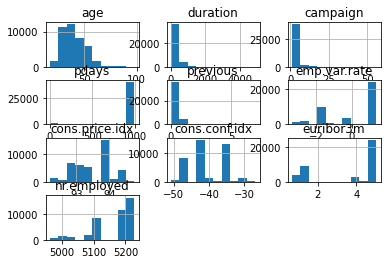

In [19]:
data_add_full.hist()

In [20]:
data_add_full.corr()

age  duration  campaign     pdays  previous  \
age             1.000000 -0.000866  0.004594 -0.034369  0.024365   
duration       -0.000866  1.000000 -0.071699 -0.047577  0.020640   
campaign        0.004594 -0.071699  1.000000  0.052584 -0.079141   
pdays          -0.034369 -0.047577  0.052584  1.000000 -0.587514   
previous        0.024365  0.020640 -0.079141 -0.587514  1.000000   
emp.var.rate   -0.000371 -0.027968  0.150754  0.271004 -0.420489   
cons.price.idx  0.000857  0.005312  0.127836  0.078889 -0.203130   
cons.conf.idx   0.129372 -0.008173 -0.013733 -0.091342 -0.050936   
euribor3m       0.010767 -0.032897  0.135133  0.296899 -0.454494   
nr.employed    -0.017725 -0.044703  0.144095  0.372605 -0.501333   

                emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  \
age                -0.000371        0.000857       0.129372   0.010767   
duration           -0.027968        0.005312      -0.008173  -0.032897   
campaign            0.150754        0.127836      -0.013733   0.135133   
pdays               0.271004        0.078889      -0.091342   0.296899   
previous           -0.420489       -0.203130      -0.050936  -0.454494   
emp.var.rate        1.000000        0.775334       0.196041   0.972245   
cons.price.idx      0.775334        1.000000       0.058986   0.688230   
cons.conf.idx       0.196041        0.058986       1.000000   0.277686   
euribor3m           0.972245        0.688230       0.277686   1.000000   
nr.employed         0.906970        0.522034       0.100513   0.945154   

                nr.employed  
age               -0.017725  
duration          -0.044703  
campaign           0.144095  
pdays              0.372605  
previous          -0.501333  
emp.var.rate       0.906970  
cons.price.idx     0.522034  
cons.conf.idx      0.100513  
euribor3m          0.945154  
nr.employed        1.000000

<AxesSubplot:>

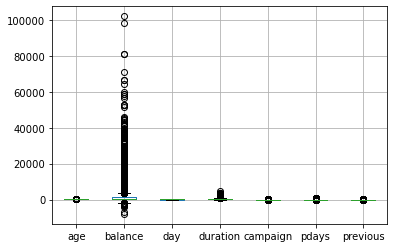

In [11]:
data_add_full.boxplot()

In [55]:
# Overview of data (bank-additional-full.csv)
pdp.ProfileReport(data_add_full)

Summarize dataset:   0%|          | 0/34 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
data_add_full.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

In [167]:
data_add_full[data_add_full.duplicated()]

age          job   marital            education  default housing loan  \
1266    39  blue-collar   married             basic.6y       no      no   no   
12261   36      retired   married              unknown       no      no   no   
14234   27   technician    single  professional.course       no      no   no   
16956   47   technician  divorced          high.school       no     yes   no   
18465   32   technician    single  professional.course       no     yes   no   
20216   55     services   married          high.school  unknown      no   no   
20534   41   technician   married  professional.course       no     yes   no   
25217   39       admin.   married    university.degree       no      no   no   
28477   24     services    single          high.school       no     yes   no   
32516   35       admin.   married    university.degree       no     yes   no   
36951   45       admin.   married    university.degree       no      no   no   
38281   71      retired    single    university.degree       no      no   no   

         contact month day_of_week  ...  campaign  pdays  previous  \
1266   telephone   may         thu  ...         1    999         0   
12261  telephone   jul         thu  ...         1    999         0   
14234   cellular   jul         mon  ...         2    999         0   
16956   cellular   jul         thu  ...         3    999         0   
18465   cellular   jul         thu  ...         1    999         0   
20216   cellular   aug         mon  ...         1    999         0   
20534   cellular   aug         tue  ...         1    999         0   
25217   cellular   nov         tue  ...         2    999         0   
28477   cellular   apr         tue  ...         1    999         0   
32516   cellular   may         fri  ...         4    999         0   
36951   cellular   jul         thu  ...         1    999         0   
38281  telephone   oct         tue  ...         1    999         0   

          poutcome emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  \
1266   nonexistent          1.1          93.994          -36.4      4.855   
12261  nonexistent          1.4          93.918          -42.7      4.966   
14234  nonexistent          1.4          93.918          -42.7      4.962   
16956  nonexistent          1.4          93.918          -42.7      4.962   
18465  nonexistent          1.4          93.918          -42.7      4.968   
20216  nonexistent          1.4          93.444          -36.1      4.965   
20534  nonexistent          1.4          93.444          -36.1      4.966   
25217  nonexistent         -0.1          93.200          -42.0      4.153   
28477  nonexistent         -1.8          93.075          -47.1      1.423   
32516  nonexistent         -1.8          92.893          -46.2      1.313   
36951  nonexistent         -2.9          92.469          -33.6      1.072   
38281  nonexistent         -3.4          92.431          -26.9      0.742   

       nr.employed    y  
1266        5191.0   no  
12261       5228.1   no  
14234       5228.1   no  
16956       5228.1   no  
18465       5228.1   no  
20216       5228.1   no  
20534       5228.1   no  
25217       5195.8   no  
28477       5099.1   no  
32516       5099.1   no  
36951       5076.2  yes  
38281       5017.5   no  

[12 rows x 21 columns]

***21 data is duplicated data***

***
***
## Data Cleaning 
<a id="cleaning"></a>
***
Data imputation is implemented for futhrer analyses in following sections.

In [136]:
df_copy = data_add_full.copy()
df_copy

age          job  marital            education  default housing loan  \
0       56    housemaid  married             basic.4y       no      no   no   
1       57     services  married          high.school  unknown      no   no   
2       37     services  married          high.school       no     yes   no   
3       40       admin.  married             basic.6y       no      no   no   
4       56     services  married          high.school       no      no  yes   
...    ...          ...      ...                  ...      ...     ...  ...   
41183   73      retired  married  professional.course       no     yes   no   
41184   46  blue-collar  married  professional.course       no      no   no   
41185   56      retired  married    university.degree       no     yes   no   
41186   44   technician  married  professional.course       no      no   no   
41187   74      retired  married  professional.course       no     yes   no   

         contact month day_of_week  ...  campaign  pdays  previous  \
0      telephone   may         mon  ...         1    999         0   
1      telephone   may         mon  ...         1    999         0   
2      telephone   may         mon  ...         1    999         0   
3      telephone   may         mon  ...         1    999         0   
4      telephone   may         mon  ...         1    999         0   
...          ...   ...         ...  ...       ...    ...       ...   
41183   cellular   nov         fri  ...         1    999         0   
41184   cellular   nov         fri  ...         1    999         0   
41185   cellular   nov         fri  ...         2    999         0   
41186   cellular   nov         fri  ...         1    999         0   
41187   cellular   nov         fri  ...         3    999         1   

          poutcome emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  \
0      nonexistent          1.1          93.994          -36.4      4.857   
1      nonexistent          1.1          93.994          -36.4      4.857   
2      nonexistent          1.1          93.994          -36.4      4.857   
3      nonexistent          1.1          93.994          -36.4      4.857   
4      nonexistent          1.1          93.994          -36.4      4.857   
...            ...          ...             ...            ...        ...   
41183  nonexistent         -1.1          94.767          -50.8      1.028   
41184  nonexistent         -1.1          94.767          -50.8      1.028   
41185  nonexistent         -1.1          94.767          -50.8      1.028   
41186  nonexistent         -1.1          94.767          -50.8      1.028   
41187      failure         -1.1          94.767          -50.8      1.028   

       nr.employed    y  
0           5191.0   no  
1           5191.0   no  
2           5191.0   no  
3           5191.0   no  
4           5191.0   no  
...            ...  ...  
41183       4963.6  yes  
41184       4963.6   no  
41185       4963.6   no  
41186       4963.6  yes  
41187       4963.6   no  

[41188 rows x 21 columns]

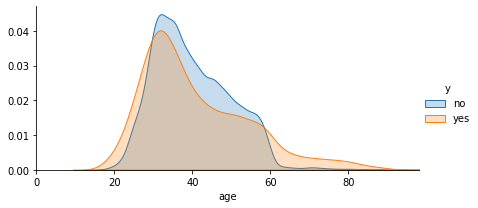

In [70]:
# Age distribution
facet = sns.FacetGrid(df_copy, hue="y",aspect=2)
facet.map(sns.kdeplot,'age',shade= True)
facet.set(xlim=(0, df_copy.loc[:,'age'].max()))
facet.add_legend()
plt.show()

In [137]:
# 'y' is renamed to 'subscribed' and 'yes'/'no' are repalced to 1/0
df_copy['y'] = df_copy['y'].map({'yes': 1, 'no': 0})
df_copy = df_copy.rename(columns={'y': 'subscribed'})

# 'pdays':999 is repalced to -1 
df_copy['pdays'] = df_copy['pdays'].replace(999,-1)

# Month: abbr => numeric 
df_copy['month'] = df_copy['month'].apply(lambda x: month_abbr2num(x))

In [138]:
df_copy

age          job  marital            education  default housing loan  \
0       56    housemaid  married             basic.4y       no      no   no   
1       57     services  married          high.school  unknown      no   no   
2       37     services  married          high.school       no     yes   no   
3       40       admin.  married             basic.6y       no      no   no   
4       56     services  married          high.school       no      no  yes   
...    ...          ...      ...                  ...      ...     ...  ...   
41183   73      retired  married  professional.course       no     yes   no   
41184   46  blue-collar  married  professional.course       no      no   no   
41185   56      retired  married    university.degree       no     yes   no   
41186   44   technician  married  professional.course       no      no   no   
41187   74      retired  married  professional.course       no     yes   no   

         contact  month day_of_week  ...  campaign  pdays  previous  \
0      telephone      5         mon  ...         1     -1         0   
1      telephone      5         mon  ...         1     -1         0   
2      telephone      5         mon  ...         1     -1         0   
3      telephone      5         mon  ...         1     -1         0   
4      telephone      5         mon  ...         1     -1         0   
...          ...    ...         ...  ...       ...    ...       ...   
41183   cellular     11         fri  ...         1     -1         0   
41184   cellular     11         fri  ...         1     -1         0   
41185   cellular     11         fri  ...         2     -1         0   
41186   cellular     11         fri  ...         1     -1         0   
41187   cellular     11         fri  ...         3     -1         1   

          poutcome emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  \
0      nonexistent          1.1          93.994          -36.4      4.857   
1      nonexistent          1.1          93.994          -36.4      4.857   
2      nonexistent          1.1          93.994          -36.4      4.857   
3      nonexistent          1.1          93.994          -36.4      4.857   
4      nonexistent          1.1          93.994          -36.4      4.857   
...            ...          ...             ...            ...        ...   
41183  nonexistent         -1.1          94.767          -50.8      1.028   
41184  nonexistent         -1.1          94.767          -50.8      1.028   
41185  nonexistent         -1.1          94.767          -50.8      1.028   
41186  nonexistent         -1.1          94.767          -50.8      1.028   
41187      failure         -1.1          94.767          -50.8      1.028   

       nr.employed  subscribed  
0           5191.0           0  
1           5191.0           0  
2           5191.0           0  
3           5191.0           0  
4           5191.0           0  
...            ...         ...  
41183       4963.6           1  
41184       4963.6           0  
41185       4963.6           0  
41186       4963.6           1  
41187       4963.6           0  

[41188 rows x 21 columns]

In [141]:
columns = ['job', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed']
df_gp = grouped_data_summary(df_copy, columns , ['subscribed'], ['sum', 'mean'], ['Count', 'Rate'])

In [100]:
df_gp['pdays']

pdays  Count      Rate
0      -1   3673  0.092582
1       0     10  0.666667
2       1      8  0.307692
3       2     37  0.606557
4       3    298  0.678815
5       4     63  0.533898
6       5     29  0.630435
7       6    289  0.701456
8       7     40  0.666667
9       8     12  0.666667
10      9     35  0.546875
11     10     30  0.576923
12     11     15  0.535714
13     12     26  0.448276
14     13     28  0.777778
15     14     11  0.550000
16     15     16  0.666667
17     16      6  0.545455
18     17      2  0.250000
19     18      4  0.571429
20     19      1  0.333333
21     20      0  0.000000
22     21      2  1.000000
23     22      2  0.666667
24     25      1  1.000000
25     26      1  1.000000
26     27      1  1.000000

***
***
## Visualisation
<a id="visualisations"></a>
*** 
Using visualisation tools such as Matplotlib, Seaborn and Plotly, key features of the data are visulaised. The custom-made function defined in the [Function](#function) section is also used.

***
**Subscription rate**
***

***
**Job**
***

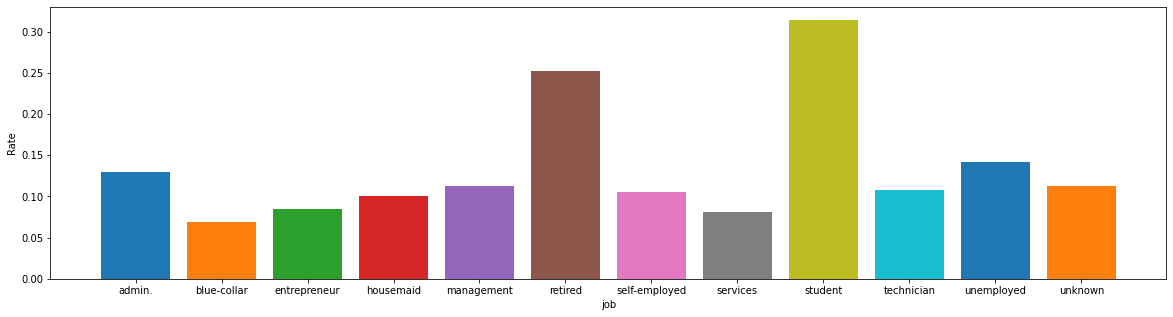

In [47]:
barplot_plt(df_gp, ['job'], 'Rate', plot_ax=0, fig_unit_size=[20, 5])

***Key findings***  
- 'stundet' and 'retired' clients have higher subscription rate (>20%)  
- others are below 15%

***
**Education**
***

In [162]:
fig = px.bar(df_gp['education'], x='education', y='Count')
fig.show()

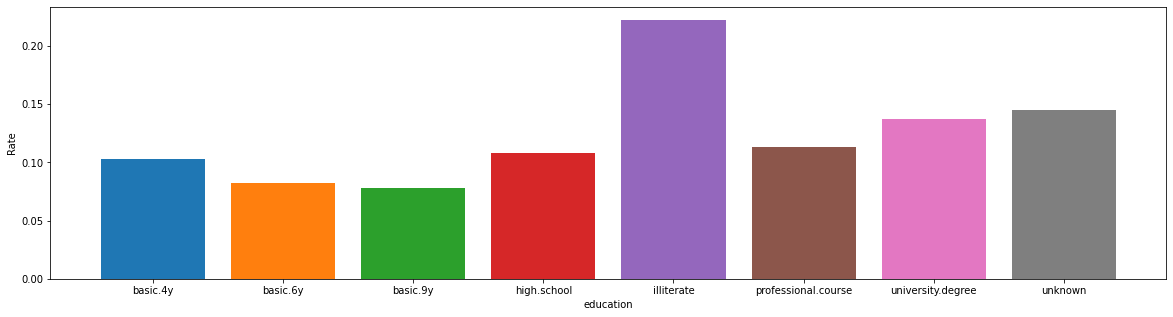

In [46]:
barplot_plt(df_gp, ['education'], 'Rate', plot_ax=0, fig_unit_size=[20, 5])

***Key findings***
- illiterate has higher subscription rate while the sbscription count is only 4 out of 18 clients. 

***
**Default**: has credit in default? (categorical: 'no','yes','unknown')
***

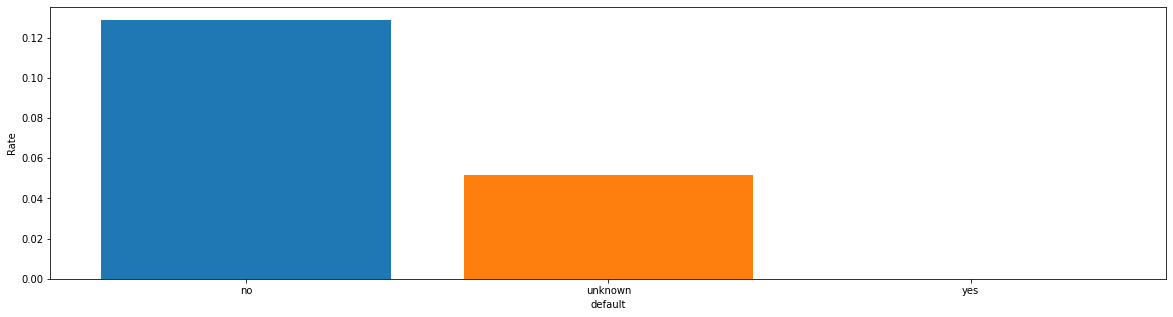

In [101]:
barplot_plt(df_gp, ['default'], 'Rate', plot_ax=0, fig_unit_size=[20, 5])

***Key findings***  
Clients who have credit in default did not subscribe (0% subscription)

***
**Month**: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
***

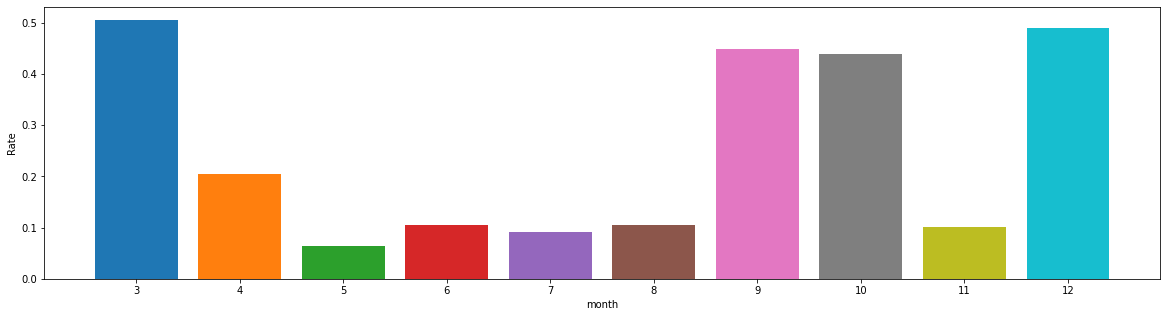

In [140]:
barplot_plt(df_gp, ['month'], 'Rate', plot_ax=0, fig_unit_size=[20, 5])

***Key findings***
- January and February have no subscription
- March, September, October and December have high subscription rate (~50%)
- The other months: below 20%

***
**Day of week**
***

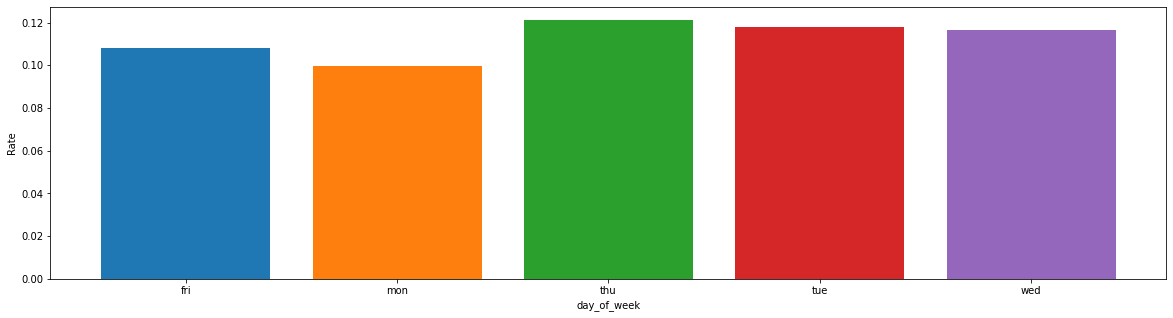

In [80]:
barplot_plt(df_gp, ['day_of_week'], 'Rate', plot_ax=0, fig_unit_size=[20, 5])

***
**Marital**
***

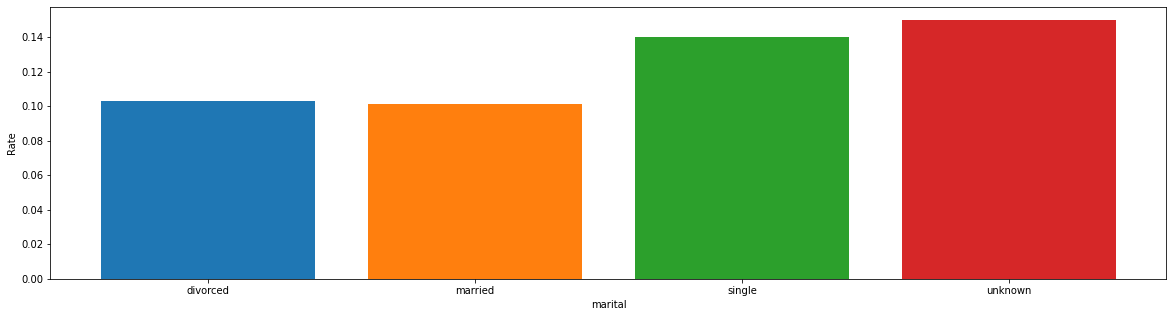

In [53]:
barplot_plt(df_gp, ['marital'], 'Rate', plot_ax=0, fig_unit_size=[20, 5])

***
**Housing**
***

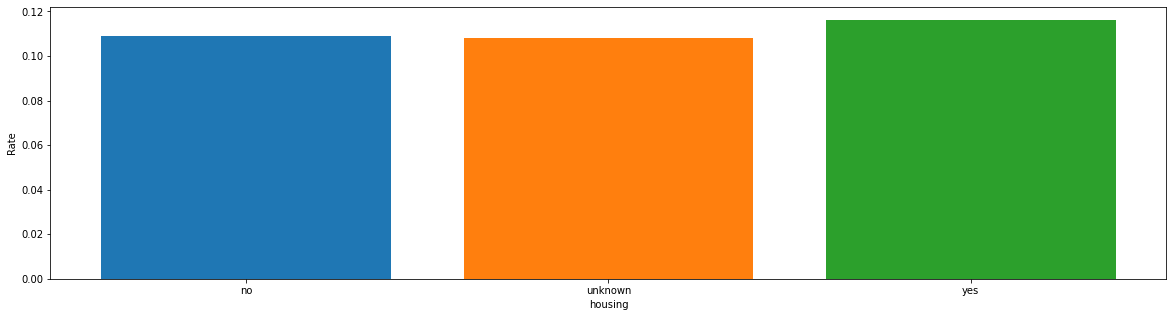

In [52]:
barplot_plt(df_gp, ['housing'], 'Rate', plot_ax=0, fig_unit_size=[20, 5])

***
**Contact**
***

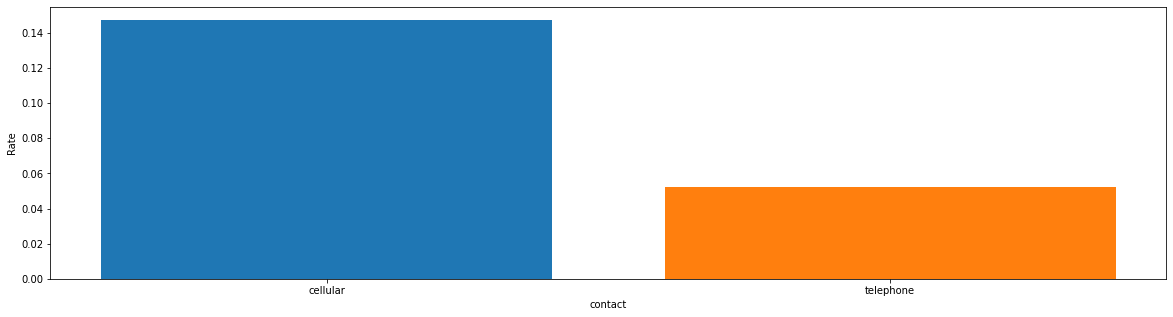

In [103]:
barplot_plt(df_gp, ['contact'], 'Rate', plot_ax=0, fig_unit_size=[20, 5])

***
**Campaign**
***

In [150]:
# barplot_plt(df_gp, ['campaign'], 'Count', plot_ax=0, fig_unit_size=[20, 5])
fig = px.bar(df_gp['campaign'], x='campaign', y='Count')
fig.show()

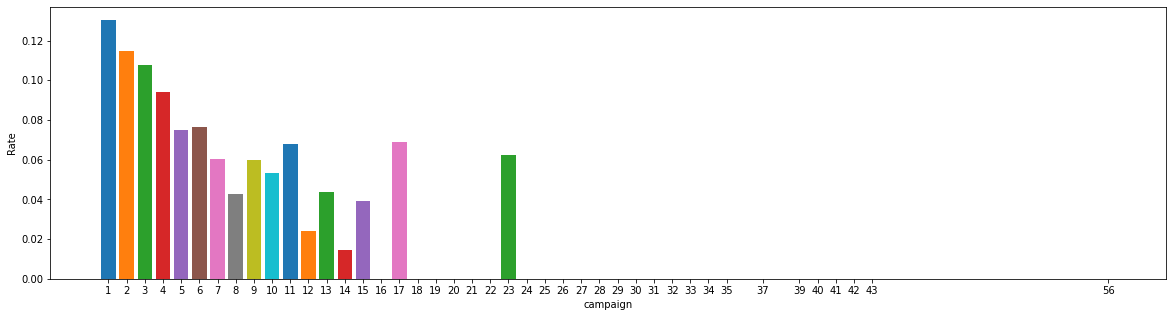

In [51]:
barplot_plt(df_gp, ['campaign'], 'Rate', plot_ax=0, fig_unit_size=[20, 5])

***
**Loan**
***

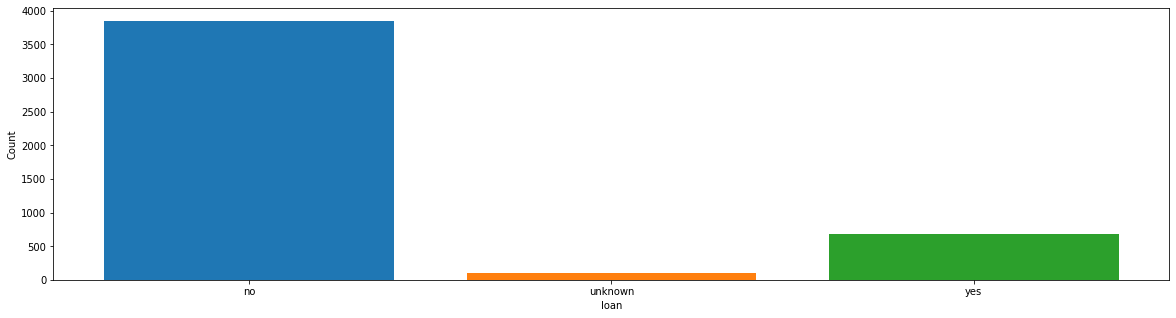

In [151]:
barplot_plt(df_gp, ['loan'], 'Count', plot_ax=0, fig_unit_size=[20, 5])

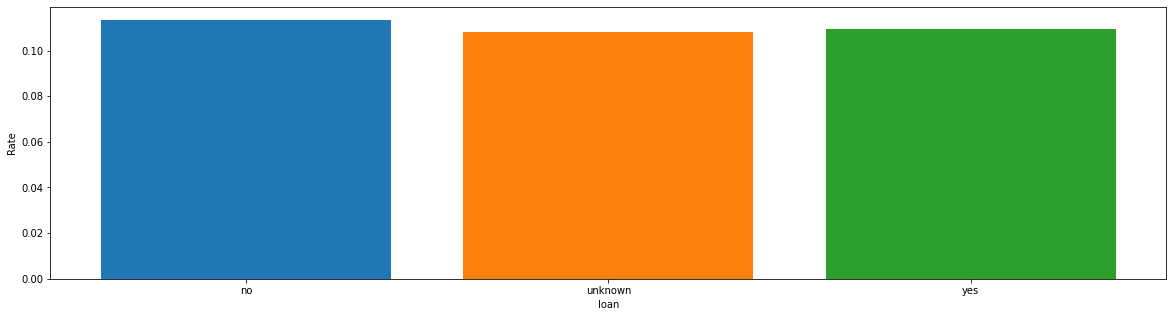

In [142]:
barplot_plt(df_gp, ['loan'], 'Rate', plot_ax=0, fig_unit_size=[20, 5])

***
**pdays**
***

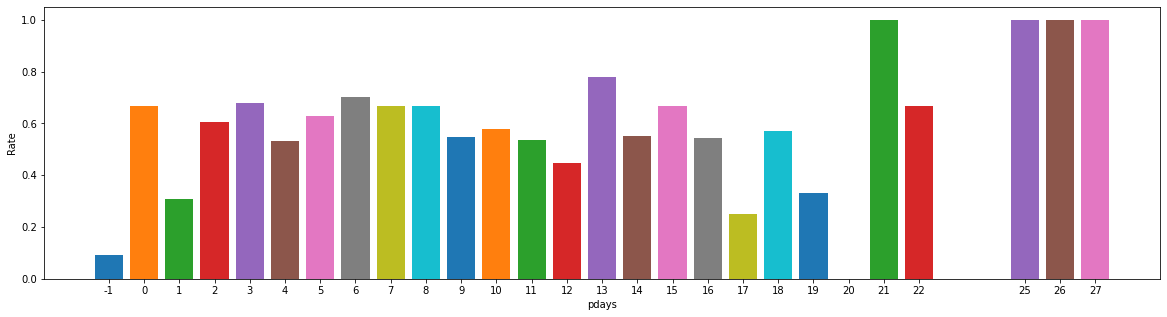

In [77]:
barplot_plt(df_gp, ['pdays'], 'Rate', plot_ax=0, fig_unit_size=[20, 5])

***
**previous**
***

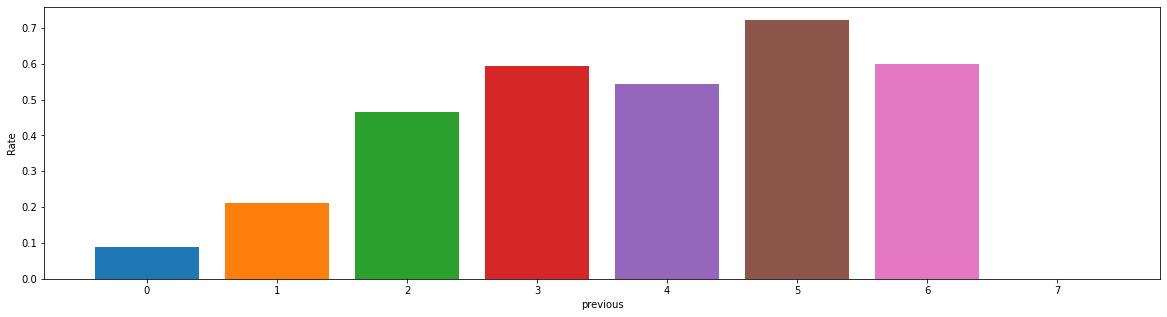

In [104]:
barplot_plt(df_gp, ['previous'], 'Rate', plot_ax=0, fig_unit_size=[20, 5])

***
**poutcome**
***

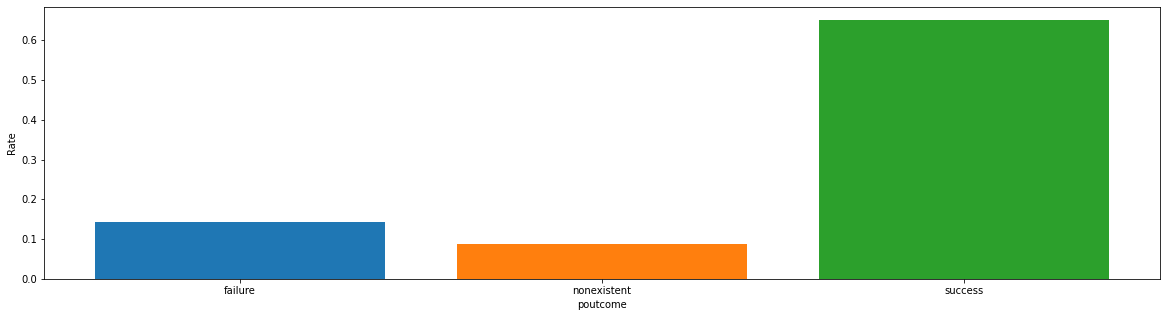

In [105]:
barplot_plt(df_gp, ['poutcome'], 'Rate', plot_ax=0, fig_unit_size=[20, 5])

***
***
**Social and economic context attributes**
***

In [155]:
# barplot_plt(df_gp, ['emp.var.rate'], 'Rate', plot_ax=0, fig_unit_size=[20, 5])

In [154]:
# barplot_plt(df_gp, ['cons.price.idx'], 'Rate', plot_ax=0, fig_unit_size=[20, 5])

In [153]:
# barplot_plt(df_gp, ['cons.conf.idx'], 'Rate', plot_ax=0, fig_unit_size=[20, 5])

In [152]:
# barplot_plt(df_gp, ['euribor3m'], 'Rate', plot_ax=0, fig_unit_size=[20, 5])

In [157]:
# barplot_plt(df_gp, ['nr.employed'], 'Rate', plot_ax=0, fig_unit_size=[20, 5])

## Fearture Engineering
<a id="feature"></a>
***
Based on the discovery above, raw data is processed to modify exisiting features or extract/create new features.  

## Preprocessing
<a id="preprocess"></a>
*** 
Datasets are preprocessed for model development.

# Model Deployment
<a id="modeldep"></a>
Binary classification models are used for model development to predict the client's decision.

## Model Development
<a id="developmodel"></a>

## Model Tuning
<a id="modeltune"></a>

## Model Validation
<a id="validate"></a>

# Deploy
<a id="deploy"></a>